In [1]:
import tensorflow as tf
tf.__version__ 

'2.3.0'

In [2]:
# Import The Libraries 

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [19]:
# Paths
train_Path = '/kaggle/input/reduced-mri-scans-data/dataset/train-data'
test_Path = '/kaggle/input/reduced-mri-scans-data/dataset/test-data'

In [20]:
# Set Resize variable
IMAGE_SIZE = [224, 224] # This is my desired image size... and also ResNet50 accepts image of 224*224.

In [21]:
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

In [22]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
for layer in resnet.layers:
    layer.trainable = False
    
# This will let us use the default weights used by the imagenet.    

In [24]:
# Usefule for getting number of output classes.
# folders = glob('../input/car-brand-images-dataset/Train/*')
folders = glob(train_Path + '/*')
folders

['/kaggle/input/reduced-mri-scans-data/dataset/train-data/zero',
 '/kaggle/input/reduced-mri-scans-data/dataset/train-data/one']

In [25]:
car_label = ['zero methylation','one methylation']

In [26]:
# Set the flatten layer.
x = Flatten() (resnet.output)

In [27]:
prediction = Dense(len(folders), activation = 'softmax')(x)

In [28]:
# Create a model Object
model = Model(inputs = resnet.input, outputs = prediction)

In [29]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [30]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [31]:
# Use the Image Data Generator

# from tensorflow.keras.proprocessing.image import ImageDataGenerator

In [32]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [33]:
training_set = train_datagen.flow_from_directory(
    train_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' # As we have more than 2 so using categorical.. for 2 we might have used binary.
)

Found 12952 images belonging to 2 classes.


In [34]:
test_set = train_datagen.flow_from_directory(
    test_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 4601 images belonging to 1 classes.


In [35]:
# Fir the model.

history = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 50,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

Epoch 1/50
405/405 [==============================] - 245s 606ms/step - loss: 1.0061 - accuracy: 0.5757 - val_loss: 1.7105 - val_accuracy: 0.8539
Epoch 2/50
405/405 [==============================] - 206s 509ms/step - loss: 0.8985 - accuracy: 0.5904 - val_loss: 1.7928 - val_accuracy: 0.8133
Epoch 3/50
405/405 [==============================] - 206s 508ms/step - loss: 0.8300 - accuracy: 0.6065 - val_loss: 2.2180 - val_accuracy: 0.9598
Epoch 4/50
405/405 [==============================] - 203s 502ms/step - loss: 0.8685 - accuracy: 0.6132 - val_loss: 1.8928 - val_accuracy: 0.7109
Epoch 6/50
405/405 [==============================] - 202s 499ms/step - loss: 0.7026 - accuracy: 0.6434 - val_loss: 1.7488 - val_accuracy: 0.6864
Epoch 7/50
405/405 [==============================] - 204s 505ms/step - loss: 0.8075 - accuracy: 0.6284 - val_loss: 3.6357 - val_accuracy: 0.9891
Epoch 8/50
405/405 [==============================] - 204s 503ms/step - loss: 0.7543 - accuracy: 0.6387 - val_loss: 2.5864 -

# Visualize

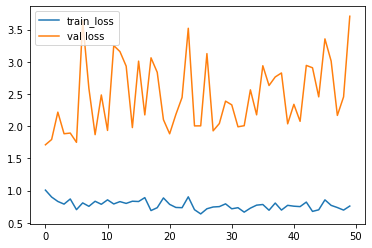

In [36]:
# Plot the Loss

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

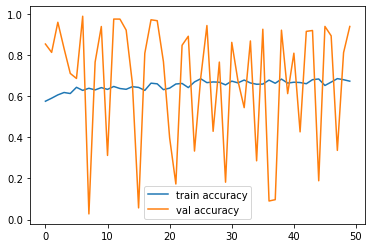

In [37]:
# Plot the Accuracy
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')

# Save the Model

In [38]:
# Save it as a h5 file
from tensorflow.keras.models import load_model

model.save('t1w_mri_scans_resnet50.h5')

# Predict

## Prediction On test data

In [55]:
prediction = model.predict(test_set)

In [56]:
prediction
len(prediction)

4601

In [57]:
prediction = np.argmax(prediction, axis = 1)
prediction
# print(len(prediction))

array([1, 0, 0, ..., 0, 0, 0])

In [65]:
# True labels
true_labels = test_set.classes

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, prediction)
precision = precision_score(true_labels, prediction, average='weighted')
recall = recall_score(true_labels, prediction, average='weighted')
f1 = f1_score(true_labels, prediction, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9387089763094979
Precision: 1.0
Recall: 0.9387089763094979
F1 Score: 0.9683856502242153
